In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

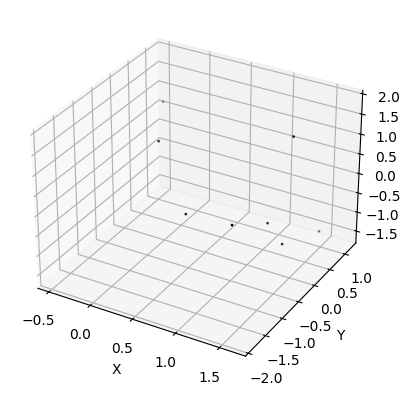

In [32]:

N0_particle = 2 ** 3

XP0 = np.random.uniform(-2, 2, N0_particle) 
YP0 = np.random.uniform(-2, 2, N0_particle)
ZP0 = np.random.uniform(-2, 2, N0_particle)

St0 = 1
R0 = 1

xl, xr = -2, 2
yl, yr = -2, 2
zd, zu = -2, 2

dx_col, dy_col, dz_col = 1, 1, 1
Nx_col, Ny_col, Nz_col = 4, 4, 4
gridA_xc, gridA_yc, gridA_zc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), 
                                           np.linspace(yl+dy_col/2, yr-dy_col, Ny_col), 
                                           np.linspace(zd+dz_col/2, zu-dz_col/2, Nz_col), indexing='ij')
gridB_xc, gridB_yc, gridB_zc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yl, yr, Ny_col+1), np.linspace(zd, zu, Nz_col+1), indexing='ij')

# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # Plot lines along x-axis
# for i in range(Ny_col):
#     for j in range(Nz_col):
#         ax.plot(gridA_xc[:, i, j], gridA_yc[:, i, j], gridA_zc[:, i, j], color='r',linestyle='--')

# # Plot lines along y-axis
# for i in range(Nx_col):
#     for j in range(Nz_col):
#         ax.plot(gridA_xc[i, :, j], gridA_yc[i, :, j], gridA_zc[i, :, j], color='g',linestyle='--')


# # Plot lines along z-axis
# for i in range(Nx_col):
#     for j in range(Ny_col):
#         ax.plot(gridA_xc[i, j, :], gridA_yc[i, j, :], gridA_zc[i, j, :], color='b',linestyle='--')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(XP0, YP0, ZP0,s=1, c='k', marker='o')


plt.show()

In [33]:
Bubbles_df_ini = np.zeros((N0_particle, 15), dtype=np.float64)

# first column is bubbles ID
Bubbles_df_ini[:, 0] = np.arange(N0_particle)

# second column is bubbles X position
Bubbles_df_ini[:, 1] = XP0.flatten().astype(float)

# third column is bubbles Y position   
Bubbles_df_ini[:, 2] = YP0.flatten().astype(float)

# fourth column is bubbles Z position
Bubbles_df_ini[:, 3] = ZP0.flatten().astype(float)

# fourth column is bubbles x-velocity
Bubbles_df_ini[:, 4] = np.zeros(N0_particle)

# fifth column is bubbles y-velocity
Bubbles_df_ini[:, 5] = np.zeros(N0_particle)

# sixth column is bubbles z-velocity
Bubbles_df_ini[:, 6] = np.zeros(N0_particle)

# sixth column is bubbles Stokes number
Bubbles_df_ini[:, 7] = St0

# seventh column is bubbles slaved status
Bubbles_df_ini[:, 8] = False

# eighth column is bubbles gridA x-index
Bubbles_df_ini[:, 9] = np.floor((Bubbles_df_ini[:, 1] - xl ) / dx_col).astype(int)

# ninth column is bubbles gridA y-index
Bubbles_df_ini[:, 10] = np.floor((Bubbles_df_ini[:, 2] - yl ) / dy_col).astype(int)

# tenth column is bubbles gridA z-index
Bubbles_df_ini[:, 11] = np.floor((Bubbles_df_ini[:, 3] - zd ) / dz_col).astype(int)

# tenth column is bubbles gridB x-index
Bubbles_df_ini[:, 12] = np.floor((Bubbles_df_ini[:, 1]- xl + dx_col / 2) / dx_col).astype(int)

# eleventh column is bubbles gridB y-index	
Bubbles_df_ini[:, 13] = np.floor((Bubbles_df_ini[:, 2]- yl + dy_col / 2) / dy_col).astype(int)

# twelfth column is bubbles gridB z-index
Bubbles_df_ini[:, 14] = np.floor((Bubbles_df_ini[:, 3]- zd + dz_col / 2) / dz_col).astype(int)

# ditch the ones about to leave the domain 
Bubbles_df_ini = Bubbles_df_ini[(Bubbles_df_ini[:, 1] >= xl) & (Bubbles_df_ini[:, 1] < xr) 
                                & (Bubbles_df_ini[:, 2] >= yl) & (Bubbles_df_ini[:, 2] < yr)
                                & (Bubbles_df_ini[:, 3] >= zd) & (Bubbles_df_ini[:, 3] < zu)]

In [34]:
Bubbles_df_before_merge = Bubbles_df_ini.copy()
gridA_size = gridA_xc.shape
gridB_size = gridB_xc.shape

In [35]:
def put_bubbles_in_cell(bubbles_df: np.ndarray):
    '''
    inputs: bubbles_df after advection
    modifies the cell index of the bubbles dataframe in place
    '''
    bubbles_df[:, 9] = np.floor((bubbles_df[:, 1] - xl ) / dx_col).astype(int)
    bubbles_df[:, 10] = np.floor((bubbles_df[:, 2] - yl ) / dy_col).astype(int)
    bubbles_df[:, 11] = np.floor((bubbles_df[:, 3] - zd ) / dz_col).astype(int)
    bubbles_df[:, 12] = np.floor((bubbles_df[:, 1]- xl + dx_col / 2) / dx_col).astype(int)
    bubbles_df[:, 13] = np.floor((bubbles_df[:, 2]- yl + dy_col / 2) / dy_col).astype(int)
    bubbles_df[:, 14] = np.floor((bubbles_df[:, 3]- zd + dz_col / 2) / dz_col).astype(int)

    return bubbles_df


def merge_bubbles(Bubbles_df_ini: np.ndarray) -> np.ndarray:

    Bubbles_df_new = Bubbles_df_ini.copy()
    
    Fbub_A = np.zeros(gridA_size)
    Fbub_B = np.zeros(gridB_size)
    drawer_A = {}
    drawer_B = {}
    masters_slaves_dict = {}

    # initialize the bubble field and the drawers based on the initial bubble distribution

    for i in range(len(Bubbles_df_ini)):
        Fbub_A[Bubbles_df_ini[i, 9].astype(int), Bubbles_df_ini[i, 10].astype(int), Bubbles_df_ini[i, 11].astype(int)] += 1
        Fbub_B[Bubbles_df_ini[i, 12].astype(int), Bubbles_df_ini[i, 13].astype(int), Bubbles_df_ini[i, 14].astype(int)] += 1

        if (Bubbles_df_ini[i, 9].astype(int), Bubbles_df_ini[i, 10].astype(int), Bubbles_df_ini[i, 11].astype(int)) not in drawer_A:
            drawer_A[(Bubbles_df_ini[i, 9].astype(int), Bubbles_df_ini[i, 10].astype(int), Bubbles_df_ini[i, 11].astype(int))] = [Bubbles_df_ini[i, 0]]
        else:
            drawer_A[(Bubbles_df_ini[i, 9].astype(int), Bubbles_df_ini[i, 10].astype(int), Bubbles_df_ini[i, 11].astype(int))].append(Bubbles_df_ini[i, 0])

        if (Bubbles_df_ini[i, 12].astype(int), Bubbles_df_ini[i, 13].astype(int), Bubbles_df_ini[i, 14].astype(int)) not in drawer_B:
            drawer_B[(Bubbles_df_ini[i, 12].astype(int), Bubbles_df_ini[i, 13].astype(int), Bubbles_df_ini[i, 14].astype(int))] = [Bubbles_df_ini[i, 0]]
        else:
            drawer_B[(Bubbles_df_ini[i, 12].astype(int), Bubbles_df_ini[i, 13].astype(int), Bubbles_df_ini[i, 14].astype(int))].append(Bubbles_df_ini[i, 0])

    # return Fbub_A, Fbub_B, drawer_A, drawer_B
    

def find_partner_in_cell():
    '''
    Find the closest particle in the cell (xj, yi, zk) to the particle bubble_ID, 
    using the updated dataframe
    '''

    neighbors = drawer[()]

    

In [37]:
Fbub_A, Fbub_B, drawer_A, drawer_B = merge_bubbles(Bubbles_df_ini)
drawer_A

{(3, 1, 1): [0.0, 7.0],
 (3, 3, 0): [1.0],
 (1, 3, 2): [2.0],
 (3, 0, 3): [3.0],
 (3, 1, 3): [4.0],
 (2, 1, 3): [5.0],
 (2, 0, 2): [6.0]}